# Virtual data set (VDS) reference file for CCMP_WINDS_10M6HR_L4_V3.1 using Virtualizarr

Saves VDS as parquet file. CCMP_WINDS_10M6HR_L4_V3.1 (https://doi.org/10.5067/CCMP-6HW10M-L4V31) is an L4 data set with four time steps per granule. Will concatinate along time dimension.

In [25]:
# Built-in packages
import os
import sys
import shutil

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import pandas as pd

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client
import coiled

# Other
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [2]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [3]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [4]:
# Locate CCMP file information / metadata:
granule_info = earthaccess.search_data(
    short_name="CCMP_WINDS_10M6HR_L4_V3.1",
    )

In [5]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print("Number of granules found =", len(data_s3links))
print("First few granules:")
data_s3links[0:3]

Number of granules found = 11674
First few granules:


['s3://podaac-ops-cumulus-protected/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_Wind_Analysis_19930102_V03.1_L4.nc',
 's3://podaac-ops-cumulus-protected/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_Wind_Analysis_19930103_V03.1_L4.nc',
 's3://podaac-ops-cumulus-protected/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_Wind_Analysis_19930105_V03.1_L4.nc']

## 2. Generate single-orbit reference files

One file per orbit, so one reference file per orbit.

In [6]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["time", "latitude", "longitude"]

In [7]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 32


In [8]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [ ]:
# Start up cluster and print some information about it:
client = Client(n_workers=30, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

In [10]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 3min 58s, sys: 45.5 s, total: 4min 43s
Wall time: 13min 8s


In [11]:
len(virtual_ds_list)

11674

## 3. Generate combined reference file

In [12]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='time', coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 8.74 s, sys: 342 ms, total: 9.09 s
Wall time: 8.78 s


In [13]:
# Save in JSON or PARQUET format:
fname_combined_json = 'CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.json'
fname_combined_parq = 'CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

In [27]:
# Zip PARQUET directory
shutil.make_archive('CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.parq', 'zip', 'CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.parq')

'/scratch/notebook/CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.parq.zip'

## 4. Test combined reference files

In [14]:
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

### 4.1 JSON reference file

In [15]:
%%time
data = opends_withref('CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.json', fs)
data

CPU times: user 1.92 s, sys: 135 ms, total: 2.05 s
Wall time: 1.97 s


<xarray.Dataset> Size: 775GB
Dimensions:    (latitude: 720, longitude: 1440, time: 46696)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 374kB 1993-01-02 ... 2024-12-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [18]:
lat_range = (0, 45)
lon_range = (230, 260)
time_range = (np.datetime64("2010-01-01"), np.datetime64("2011-01-01"))
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=slice(*time_range))
data_subset

<xarray.Dataset> Size: 505MB
Dimensions:    (latitude: 180, longitude: 120, time: 1461)
Coordinates:
  * latitude   (latitude) float32 720B 0.125 0.375 0.625 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 480B 230.1 230.4 230.6 ... 259.4 259.6 259.9
  * time       (time) datetime64[ns] 12kB 2010-01-01 ... 2011-01-01
Data variables:
    nobs       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [19]:
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

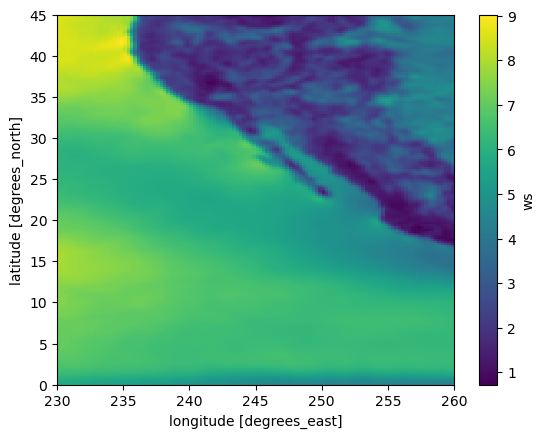

In [20]:
ws_mean_map.plot()

### 4.1 PARQUET reference file

In [21]:
%%time
data = opends_withref('CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.parq', fs)
data

CPU times: user 63.5 ms, sys: 7.89 ms, total: 71.4 ms
Wall time: 63.1 ms


<xarray.Dataset> Size: 775GB
Dimensions:    (latitude: 720, longitude: 1440, time: 46696)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 374kB 1993-01-02 ... 2024-12-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [22]:
lat_range = (0, 45)
lon_range = (230, 260)
time_range = (np.datetime64("2010-01-01"), np.datetime64("2011-01-01"))
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=slice(*time_range))
data_subset

<xarray.Dataset> Size: 505MB
Dimensions:    (latitude: 180, longitude: 120, time: 1461)
Coordinates:
  * latitude   (latitude) float32 720B 0.125 0.375 0.625 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 480B 230.1 230.4 230.6 ... 259.4 259.6 259.9
  * time       (time) datetime64[ns] 12kB 2010-01-01 ... 2011-01-01
Data variables:
    nobs       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 126MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                   CF-1.7 ACDD-1.3
    comment:                       none
    contact:                       Remote Sensing Systems, support@remss.com
    contributor_name:              Carl Mears, Tong Lee, Frank Wentz
    contributor_role:              Principal-Investigator, Co-Investigator, C...
    creator_email:                 support@remss.com
    ...                            ...
    publisher_url:                 https://podaac.jpl.nasa.gov
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    source:                        blend of satellite and ERA-5 winds
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...

In [23]:
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

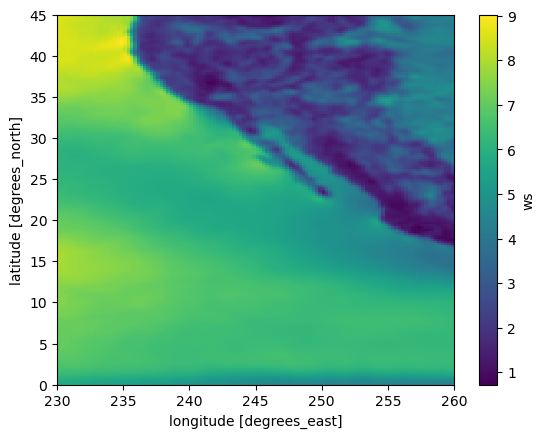

In [24]:
ws_mean_map.plot()